## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import time_intp, plot_styles, time_range
from src.reproducibility import set_seed
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
weather = pd.read_excel("data/processed_data/mesonet.xlsx")
fm = pd.read_excel("data/processed_data/ok_10h.xlsx")

## Data Process

Line up fm data to nearest half hour for now

Find a train/test period with no missing weather data and no rain

In [3]:
fm['date'] = fm['date'].dt.tz_localize('Etc/GMT+6')
fm['date'] = fm['date'].dt.tz_convert('UTC')
fm["date"] = fm["date"].dt.round("30min")
weather['date'] = weather['date'].dt.tz_localize('UTC')

In [4]:
# train_start = fm.date.min()
# train_end = train_start + pd.Timedelta(hours=24*7)
# test_end = fm.date.max()
train_start = pd.to_datetime('1996-04-07 12:00:00+00:00')
train_end = train_start + pd.Timedelta(hours=24*7)
test_end = train_end + pd.Timedelta(hours=24*7)

# Weather 
w_train   = weather[(weather.date <= train_end) & (weather.date >= train_start)].reset_index(drop=True)
w_test   = weather[(weather.date > train_end) & (weather.date <= test_end)].reset_index(drop=True)
print(f"Number missing Eq/rain: {len(w_train.index[w_train['rain'].isna() & w_train['Ed'].isna() & w_train['Ew'].isna()])}")
print(f"Max rain: {w_train.rain.max()}")
# FMC Observations
fm_train = fm[(fm.date >= train_start) & (fm.date <= train_end)].reset_index(drop=True)
fm_test  = fm[(fm.date > train_end) & (fm.date <= test_end)].reset_index(drop=True)

Number missing Eq/rain: 0
Max rain: 0.0


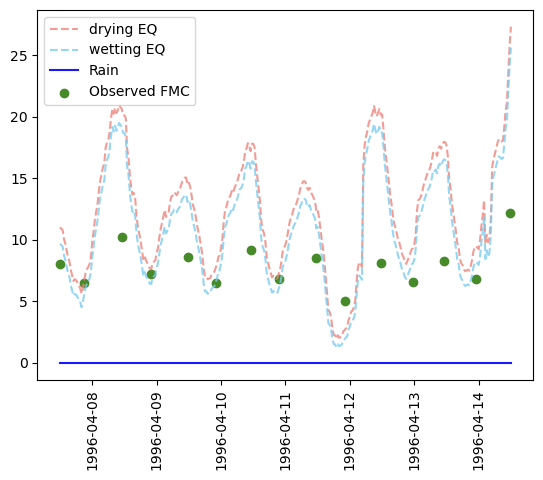

In [5]:
plt.plot(w_train.date, w_train.Ed, **plot_styles["Ed"])
plt.plot(w_train.date, w_train.Ew, **plot_styles["Ew"])
plt.plot(w_train.date, w_train.rain, **plot_styles["rain"])
_ = plt.xticks(rotation=90)
plt.scatter(fm_train.date, fm_train.fm10, **plot_styles["fm"])
plt.legend()

## Define Model

Simple Neural ODE
- Single Eq input: averaging Ed and Ew for now
- Time grid: hourly from start fm time (will evaluate sub-hourly later)
- Architecture: 2 inputs (1 weather, 1 state), 1 cell hidden layer/output 

Using tensorflow and manually implemented ODE solvers for now. For real model, tools already exist in pytorch

In [6]:
# Params for phys-initiation
T_k = 10     # timelag class
b = 0        # no bias
W_x = 1/T_k  # weight for weather input
W_h = -1/T_k # weight for state 


# Initial State
m0 = fm_train.fm10.iloc[0]
print(f"Initial State: {m0}")

# Hourly time grid
tgrid = time_range(fm_train.date.iloc[0], w_train.date.iloc[-1], freq="1h")
print(f"Number of times: {tgrid.shape[0]}")
print(f"Unique Time lags in weather: {w_train.date.diff().unique()[1:][0]}")
w_inputs = w_train.set_index("date").reindex(tgrid).reset_index()
w_inputs["E"] = (w_inputs["Ed"] + w_inputs["Ew"]) / 2
X = w_inputs.E.to_numpy()

Initial State: 8.0
Number of times: 169
Unique Time lags in weather: 0 days 00:30:00


In [7]:
# Two inputs: state h and one weather variable x
inputs = layers.Input(shape=(2,))   # [h, x]
# Single unit and ReLU
output = layers.Dense(1, activation="linear")(inputs)
# Build the model
f_theta = models.Model(inputs=inputs, outputs=output)

# Set weights manually
f_theta.layers[1].set_weights([
    np.array([[W_h], [W_x]]),
    np.array([b])
])

In [8]:
f_theta.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
input_0 = np.array([[m0, X[0]]], dtype=np.float32)
dhdt_0 = f_theta(input_0)

In [10]:
print(f"Derivative at time 0: {dhdt_0}")

Derivative at time 0: [[0.23399216]]


In [11]:
# Manual check: dhdt = (E-m0)/T_k, should match to rounding error
print(f"Manual calc: {(X[0] - m0)/T_k}")

Manual calc: 0.2339921191708001


In [12]:
def forward_euler(h, x, f, dt):
    """
    f is a neural network that expects input [[h, x]]
    """
    h = np.atleast_1d(h).astype(np.float32)
    x = np.atleast_1d(x).astype(np.float32)
    hx = np.concatenate((h, x)).reshape(1, -1)
    fhx = f(hx).numpy()[0][0] # 0th batch, 0th unit
    # print(f"dhdt nn: {fhx}")
    return h + dt*fhx

In [13]:
def forward_euler2(h, x, dt):
    """
    f is a neural network that expects input [[h, x]]
    """
    h = np.atleast_1d(h).astype(np.float32)
    x = np.atleast_1d(x).astype(np.float32)
    fhx = (x-h) / T_k
    # print(f"dhdt manual: {fhx}")
    return h + dt*fhx

In [14]:
m = np.zeros(tgrid.shape[0])
mm = np.zeros(tgrid.shape[0])
m0 = fm_train.fm10.iloc[0] # define again for clarity
m[0] = m0
mm[0] = m0
for i in range(len(tgrid) -1):
    Xi = X[i]
    m[i+1] = forward_euler2(m[i], Xi, dt=1)[0]
    mm[i+1] = forward_euler(mm[i], Xi, f_theta, dt=1)[0]

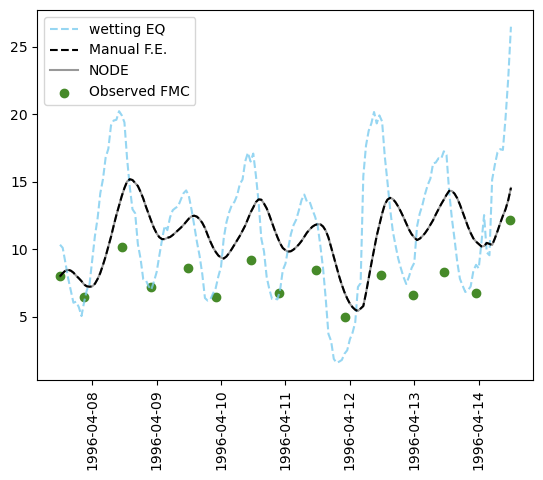

In [15]:
plt.plot(w_inputs.date, X, **plot_styles["Ew"])
plt.plot(w_inputs.date, m, color="k", linestyle="--", label="Manual F.E.")
plt.plot(w_inputs.date, mm, color="k", alpha=.4, label="NODE")
plt.scatter(fm_train.date, fm_train.fm10, **plot_styles["fm"])
_ = plt.xticks(rotation=90)
plt.legend()